<a href="https://colab.research.google.com/github/ntherndon97/COSC526_M5_SpookyAuthorship/blob/main/M5.12_TeamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 0: Import Data and 

## Unzip Files for CSV Files

In [45]:
import zipfile


# Paths to the zip files
test_zip_path = 'test.zip' # Update this with the correct path if needed
test_zip_path = 'train.zip' # Update this with the correct path if needed

# Unzip test.zip in the current directory
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

# Unzip train.zip in the current directory
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

print("Unzipping complete.")


Unzipping complete.


## Create PySpark Session

### Read test.csv

In [47]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './test.csv'
test_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

### Read train.csv

In [49]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './train.csv'
train_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

## Exploring structure, size, and distribution of information

### Training Data

In [51]:
# Find null rows with null values in the training dataset
# Only including columns that are relevant to the analysis.
print("Null rows with null value in the training dataset:")
train_df.filter(train_df.text.isNull() | train_df.author.isNull()).count()

Null rows with null value in the training dataset:


0

In [53]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



In [55]:
# Print the schema of the dataframe
print("Dataframe Schema:")
train_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



In [57]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(train_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(train_df.columns)))

Number of rows in the dataframe: 19579
Number of columns in the dataframe: 3


In [59]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(train_df.columns)

Column names of the dataframe:
['id', 'text', 'author']


In [16]:
# Show number of each author in the dataframe

eap_author_count = train_df.filter(train_df.author == 'EAP').count()
hpl_author_count = train_df.filter(train_df.author == 'HPL').count()
mws_author_count = train_df.filter(train_df.author == 'MWS').count()

# NOTE: We may want to consider removing the unknown authors from the dataset since
# they do not provide any useful information for training a model. We need an author
# to train the model to predict the author of the text.
unknown_authors = train_df.filter(train_df.author != 'MWS')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'HPL')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'EAP')
unknown_author_count = unknown_authors.count()

total_author_count = train_df.count()

print(total_author_count)

print("Number of unknown authors: " + str(unknown_author_count))
print("Percentage of unknown authors: " + str(round((unknown_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Edgar Allan Poe (EAP) entries: " + str(eap_author_count))
print("Percentage of Edgar Allan Poe (EAP) entries: " + str(round((eap_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of HP Lovecraft (HPL) entries: " + str(hpl_author_count))
print("Percentage of HP Lovecraft (HPL) entries: " + str(round((hpl_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Mary Shelley (MWS) entries: " + str(mws_author_count))
print("Percentage of Mary Shelley (MWS) entries: " + str(round((mws_author_count/total_author_count)*100)) + "%")

19579
Number of unknown authors: 1532
Percentage of unknown authors: 8%



Number of Edgar Allan Poe (EAP) entries: 7044
Percentage of Edgar Allan Poe (EAP) entries: 36%



Number of HP Lovecraft (HPL) entries: 5451
Percentage of HP Lovecraft (HPL) entries: 28%



Number of Mary Shelley (MWS) entries: 5552
Percentage of Mary Shelley (MWS) entries: 28%


### Test Data

In [61]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
test_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



In [63]:
# Print the schema of the dataframe
print("Dataframe Schema:")
test_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)



In [65]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(test_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(test_df.columns)))

Number of rows in the dataframe: 8392
Number of columns in the dataframe: 2


In [67]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(test_df.columns)

Column names of the dataframe:
['id', 'text']


# Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

## Data Cleaning

In [69]:
# Remove the rows with unknown author values from the training dataset
train_df_cleaned = train_df.filter(train_df.author == 'MWS')
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'HPL'))
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'EAP'))

## Data Pre-Processing

In [75]:
# Text tokenization and stop word removal

from pyspark.ml.feature import Tokenizer, StopWordsRemover
new_text_column_name = "tokens"

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol=new_text_column_name)
train_df_cleaned = tokenizer.transform(train_df_cleaned)

# Remove stop words from the text column
remover = StopWordsRemover(inputCol=new_text_column_name, outputCol=new_text_column_name + "_filtered")
train_df_cleaned = remover.transform(train_df_cleaned)

# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df_cleaned.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+--------------------+--------------------+
|     id|                text|author|              tokens|     tokens_filtered|
+-------+--------------------+------+--------------------+--------------------+
|id27763|How lovely is spr...|   MWS|[how, lovely, is,...|[lovely, spring, ...|
|id22965|A youth passed in...|   MWS|[a, youth, passed...|[youth, passed, s...|
|id00912|I confess that ne...|   MWS|[i, confess, that...|[confess, neither...|
|id16737|"He shall find th...|   MWS|["he, shall, find...|["he, shall, find...|
|id12799|He had escaped me...|   MWS|[he, had, escaped...|[escaped, me,, mu...|
+-------+--------------------+------+--------------------+--------------------+
only showing top 5 rows



## Data Visualizations

In [85]:
#Get individual words from tokens_filtered column
words_df = train_df_cleaned.selectExpr(f"explode({new_text_column_name}_filtered) as word")

# Count the occurrences of each word
word_counts = words_df.groupBy("word").count().orderBy('count', ascending=False)

# Show counts
word_counts.show(10)

+------+-----+
|  word|count|
+------+-----+
|   one| 1361|
|  upon| 1252|
|  even|  650|
|   yet|  618|
| might|  570|
|  like|  533|
|   old|  529|
|  must|  510|
|seemed|  503|
| first|  503|
+------+-----+
only showing top 10 rows



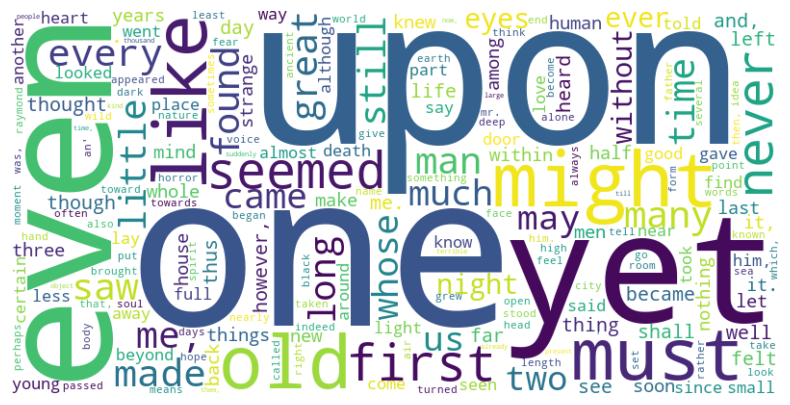

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Converting word_counts to dict
word_counts_pd = word_counts.toPandas()

word_freq_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))

#Creating wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'viridis').generate_from_frequencies(word_freq_dict)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Stage 2: Feature Extraction